SpikeCounter/batch_split_embryo_array.py /n/holyscratch01/cohen_lab/bjia/20220620_ncx_atp1a1_MOs/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20220620_ncx_atp1a1_MOs/corrected/ --expt_index morpholino

In [1]:
import sys
from pathlib import Path
import os
import importlib
import warnings
SPIKECOUNTER_PATH = Path(os.getenv("SPIKECOUNTER_PATH"))
sys.path.append(SPIKECOUNTER_PATH.as_posix())

In [11]:
import numpy as np
import skimage.io as skio
import scipy.io as scio
from scipy import ndimage, signal, stats, fft
from skimage import filters, registration, transform, exposure
import cv2

import scipy.ndimage as ndimage
import pandas as pd
import pickle
import imagesize

import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
from statannotations.Annotator import Annotator

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils

biopubs_style = SPIKECOUNTER_PATH/"config"/"bio_publications.mplstyle"
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [90]:
expt_dir_name = "20230510_nifedipine_block"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure3/", expt_dir_name)
subfolder = "corrected"
output_datadir.mkdir(parents=True, exist_ok=True)

In [4]:
expt_info = utils.process_experiment_metadata(
    pd.read_csv(rootdir /"analysis" / "experiment_data.csv"),
)
if "level_0" in expt_info.columns:
    del expt_info["level_0"]

Rough embryo segmentation

In [47]:
def generate_registration(mean_img1, mean_img2, plot=False):
    mask1, _ = images.segment_whole_embryos(mean_img1, 451, 0, 1200)
    mask2, _ = images.segment_whole_embryos(mean_img2, 451, 0, 1200)

    mean_img_thresholded1 = exposure.rescale_intensity(mean_img1, out_range=np.uint8)
    mean_img_thresholded1[~mask1] = 0
    mean_img_thresholded2 = exposure.rescale_intensity(mean_img2, out_range=np.uint8)
    mean_img_thresholded2[~mask2] = 0
    max_features = 500
    orb = cv2.ORB_create(max_features)
    kp1, des1 = orb.detectAndCompute(mean_img_thresholded1, None)
    kp2, des2 = orb.detectAndCompute(mean_img_thresholded2, None)
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(des1, des2, None)
    matches = sorted(matches, key=lambda x: x.distance)
    matches = matches[:max_features]

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs.flat[0].imshow(mean_img_thresholded1)
        for key in kp1:
            axs.flat[0].plot(key.pt[0], key.pt[1], "o", color="red", markersize=2)
        axs.flat[1].imshow(mean_img_thresholded2)
        for key in kp2:
            axs.flat[1].plot(key.pt[0], key.pt[1], "o", color="red", markersize=2)
    
    pts1 = np.zeros((len(matches), 2), dtype="float")
    pts2 = np.zeros((len(matches), 2), dtype="float")
        # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        pts1[i] = kp1[m.queryIdx].pt
        pts2[i] = kp2[m.trainIdx].pt
    (H, _) = cv2.findHomography(pts1, pts2, method=cv2.RANSAC)
    if plot:
        aligned = cv2.warpPerspective(mean_img_thresholded1, H, (mean_img_thresholded1.shape[1], mean_img_thresholded1.shape[0]))
        visualize.display_roi_overlay(aligned, mask2)
    return H

(<Figure size 1200x1100 with 1 Axes>,
 <Axes: >,
 ['#4477aa',
  '#ee6677',
  '#228833',
  '#ccbb44',
  '#66ccee',
  '#aa3377',
  '#bbbbbb',
  '#4477aa',
  '#ee6677',
  '#228833',
  '#ccbb44'],
 0.24237497455495544)

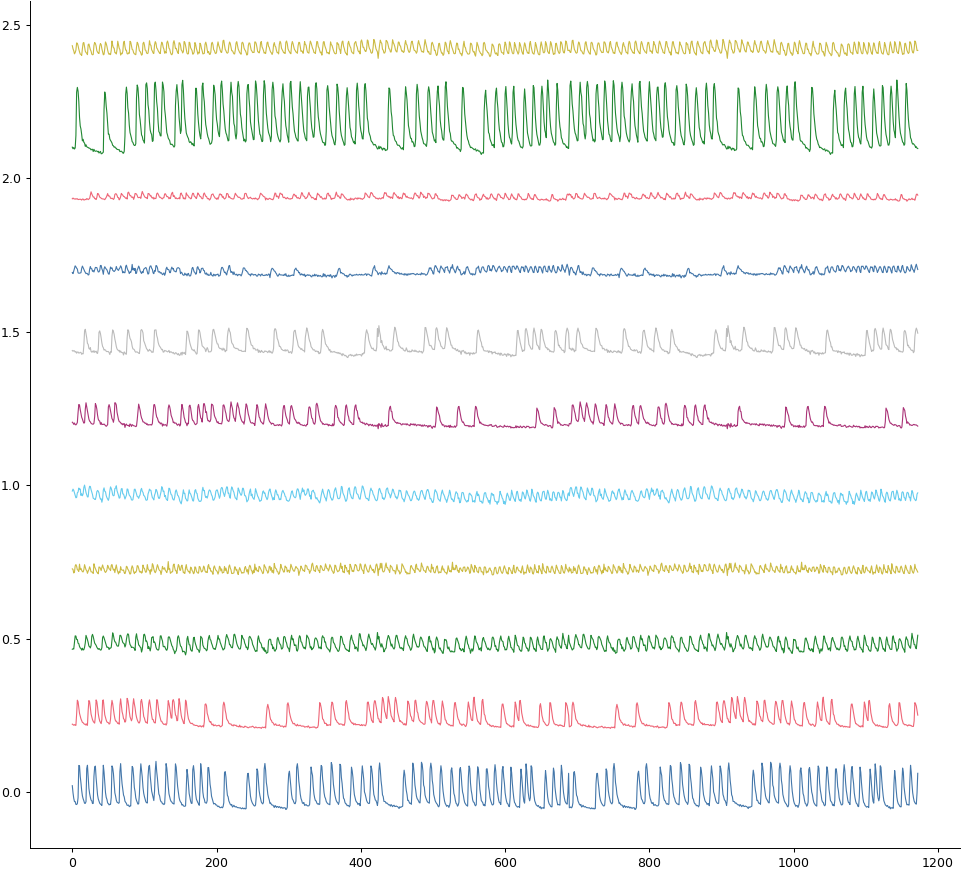

In [110]:
visualize.stackplot(dff)

In [101]:
recording_names = sorted(os.listdir(rootdir / subfolder))
manual_rois = skio.imread(rootdir / "analysis" / "start_ROIs.tif")

In [111]:
recording_dffs = {}
for idx, recording_name in enumerate(recording_names):
    if idx ==0:
        img1 = skio.imread(rootdir / subfolder / recording_name)
        mean_img1 = img1.mean(axis=0)
        tr = images.extract_roi_traces(img1, manual_rois)
        dff = traces.intensity_to_dff(tr, axis=1)
        recording_dffs[recording_name] = dff
    else:
        img2 = skio.imread(rootdir / subfolder / recording_name)
        mean_img2 = img2.mean(axis=0)
        H = generate_registration(mean_img1, mean_img2, plot=False)
        rois_transformed = cv2.warpPerspective(manual_rois, H, (manual_rois.shape[1], manual_rois.shape[0]))
        tr = images.extract_roi_traces(img2, rois_transformed)
        dff = traces.intensity_to_dff(tr, axis=1)
        recording_dffs[recording_name] = dff

In [112]:
recording_dffs.keys()

dict_keys(['111130_tnnt2aMO_t106_p1_z1.tif', '120427_nifedipine_t1_p1_z1.tif', '123851_nifedipine_washout_3_t1_p1_z1.tif', '124245_nifedipine_washout_3_t1_p1_z1.tif'])

In [113]:
recording_dffs["111130_tnnt2aMO_t106_p1_z1.tif"].shape

(11, 1173)

IndexError: index 11 is out of bounds for axis 0 with size 11

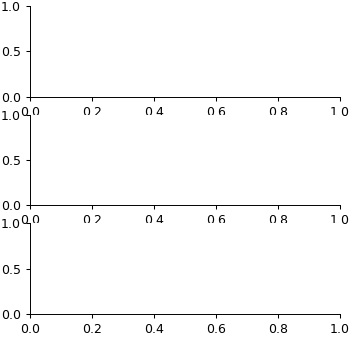

In [133]:
dt = 1/10.2
embryo = 11
fig1, axs = plt.subplots(3,1, figsize=(4, 4))
dff = recording_dffs["111130_tnnt2aMO_t106_p1_z1.tif"]
axs = axs.flat
axs[0].plot(dt*np.arange(0, dff.shape[1]), dff[embryo, :])
dff = recording_dffs["120427_nifedipine_t1_p1_z1.tif"]
axs[1].plot(dt*np.arange(0, dff.shape[1]), dff[embryo, :])
dff = recording_dffs["124245_nifedipine_washout_3_t1_p1_z1.tif"]
axs[2].plot(dt*np.arange(0, dff.shape[1]), dff[embryo, :])
for ax in axs:
    ax.set_ylim(-0.05, 0.06)
plt.tight_layout()